# Starter Notebook
This notebook contains the main code to train a GeodesyNet on accelerations synthetically generated from a mascon model.
At the end of the training a quick look at the resulting neural density field is also given.

To run this notebook we recommend to create a conda environment using the following commands:
```
 conda create -n geodesynets python=3.8 ipython numpy scipy scikit-learn  h5py matplotlib jupyter tqdm pandas
 conda activate geodesynets
 conda install -c pytorch pytorch
 conda install -c open3d-admin open3d
 pip install sobol_seq
 pip install tetgen
 conda install pyvista pyvistaqt
```

To use CUDA, you will need to run
```
 conda install pytorch torchvision cudatoolkit=10.2 -c pytorch
```

On CPU the training will still work but be slow, so use less points for the numercial quadrature and smaller batches. If you have access to a GPU everything will go much faster. With an Nvidia RTX2080Ti GPU a full training will take approximately one hour.

In [1]:
# Import our module containing helper functions
import gravann

# Core imports
import numpy as np
import pickle as pk
import os
from collections import deque

# pytorch
from torch import nn
import torch

# plotting stuff
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib notebook

# Ensure that changes in imported module (gravann most importantly) are autoreloaded
%load_ext autoreload
%autoreload 2

# If possible enable CUDA
gravann.enableCUDA()
gravann.fixRandomSeeds()
device = os.environ["TORCH_DEVICE"]
print("Will use device ",device)

Available devices  1
__pyTorch VERSION: 1.10.0
__CUDNN VERSION: 7605
__Number CUDA Devices: 1
Active CUDA Device: GPU 0
Setting default tensor type to Float32
Will use device  cuda:0


C:\ProgramData\Miniconda3\envs\geodesynet\lib\site-packages\pyvista\themes.py:123: PyvistaDeprecationWarning: use "dark" instead of "night" theme
  warnings.warn('use "dark" instead of "night" theme', PyvistaDeprecationWarning)


# Loading and visualizing the ground truth asteroid (a point cloud)

In [2]:
# We load the ground truth (a mascon model of some body)
with open("mascons/Eros.pk", "rb") as file:
    mascon_points, mascon_masses, mascon_name = pk.load(file)
    
mascon_points = torch.tensor(mascon_points)
mascon_masses = torch.tensor(mascon_masses)

# Print some information on the loaded ground truth 
# (non-dimensional units assumed. All mascon coordinates are thus in -1,1 and the mass is 1)
print("Name: ", mascon_name)
print("Number of mascons: ", len(mascon_points))
print("Total mass: ", sum(mascon_masses))

# Each mascon has a closest neighbour. The least close one is here computed (non dimensional units).
# Its a quantity that is of interest when checking mascon models coming from gravitationally stable aggregates.
print("Maximal minimal distance:",gravann.max_min_distance(mascon_points))

Name:  Eros
Number of mascons:  39554
Total mass:  tensor(1.0000, dtype=torch.float64)
Maximal minimal distance: 0.06402954459190369


<IPython.core.display.Javascript object>


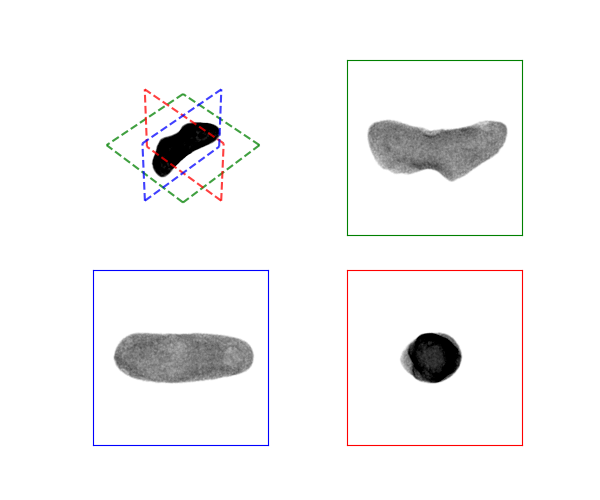

In [3]:
# Here we visualize the loaded ground truth
gravann.plot_mascon(mascon_points, mascon_masses)

# Representing the asteroid mass distribution via a neural network


## 1 - Defining the network architecture
We here use functions from our module as to not clutter the notebook, but the code is rather straight forward: a FFNN with some options.

In [4]:
# Encoding: direct encoding (i.e. feeding the network directly with the Cartesian coordinates in the unit hypercube)
# was found to work well in most cases. But more options are implemented in the module.
encoding = gravann.direct_encoding()

# The model is here a SIREN network (FFNN with sin non linearities and a final absolute value to predict the density)
model = gravann.init_network(encoding, n_neurons=100, model_type="siren", activation = gravann.AbsLayer())
#model = gravann.init_network(encoding, n_neurons=100, model_type="siren", activation = gravann.SquaredReLU())
#model = gravann.init_network(encoding, n_neurons=100, model_type="siren", activation = torch.nn.ReLU())


# When a new network is created we init empty training logs
loss_log = []
weighted_average_log = []
running_loss_log = []
n_inferences = []
# .. and we init a loss trend indicators
weighted_average = deque([], maxlen=20)

In [5]:
## IF YOU WANT TO LOAD AN ALREADY TRAINED NETWORK UNCOMMENT HERE.
## It is important that the network architecture is compatible, otherwise this will fail

model.load_state_dict(torch.load("models/eros.mdl"))

# Once a model is loaded the learned constant c (named kappa in the paper) is unknown 
# and must be relearned (ideally it should also be saved at the end of the training as it is a learned parameter)
c = gravann.compute_c_for_model(model, encoding, mascon_points, mascon_masses, use_acc = True)

C:\ProgramData\Miniconda3\envs\geodesynet\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


## 2 - Visualizing the initial neural density field
The network output is a mass density in the unit cube. Essentially a three dimensional function which we here plot via rejection sampling (for now this method is good enough)

Sampling points...: 10389it [00:04, 2221.79it/s]                                                                       


<IPython.core.display.Javascript object>


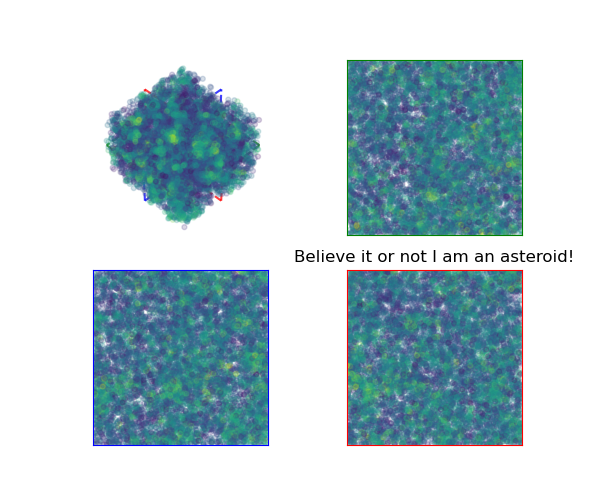

Text(0.5, 1.0, 'Believe it or not I am an asteroid!')

In [8]:
# The rejection plot will visualize the neural density field as a probability distribution function. 
# Colors represent the density magnitude (white being zero). 
# At the beginning, the whole hypercube is filled with some non vanishing density.
gravann.plot_model_rejection(model, encoding, views_2d=True, N=10000, progressbar=True, c=c)
plt.title("Believe it or not I am an asteroid!")

# Training of a geodesyNet

In [9]:
# EXPERIMENTAL SETUP ------------------------------------------------------------------------------------
# Number of points to be used to evaluate numerically the triple integral
# defining the acceleration. 
# Use <=30000 to for a quick training ... 300000 was used to produce most of the paper results
n_quadrature = 300000

# Dimension of the batch size, i.e. number of points
# where the ground truth is compared to the predicted acceleration
# at each training epoch.
# Use 100 for a quick training. 1000  was used to produce most of the paper results
batch_size = 1000

# Loss. The normalized L1 loss (kMAE in the paper) was
# found to be one of the best performing choices.
# More are implemented in the module
loss_fn = gravann.normalized_L1_loss

# The numerical Integration method. 
# Trapezoidal integration is here set over a dataset containing acceleration values,
# (it is possible to also train on values of the gravity potential, results are similar)
mc_method = gravann.ACC_trap

# The sampling method to decide what points to consider in each batch.
# In this case we sample points unifromly in a sphere and reject those that are inside the asteroid
targets_point_sampler = gravann.get_target_point_sampler(batch_size, 
                                                         limit_shape_to_asteroid="3dmeshes/Eros_lp.pk", 
                                                         method="spherical", 
                                                         bounds=[0,1])
# Here we set the optimizer
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.8, patience = 200, min_lr = 1e-9,verbose=True)

# And init the best results
best_loss = np.inf
best_model_state_dict = model.state_dict()

**Note: the cell below is explicitly typed for convenience, as this is a tutorial-ish after all, but the module gravann contains a function (train_on_batch) that does the same**

In [24]:
# TRAINING LOOP (normal training, no use of any prior shape information)------------------------
# This cell can be stopped and started again without loosing memory of the training nor its logs
torch.cuda.empty_cache()
# The main training loop
for i in range(7000):
    # Each ten epochs we resample the target points
    if (i % 10 == 0):
        target_points = targets_point_sampler()
        # We compute the labels whenever the target points are changed
        labels = gravann.ACC_L(target_points, mascon_points, mascon_masses)
    
    # We compute the values predicted by the neural density field
    predicted = mc_method(target_points, model, encoding, N=n_quadrature, noise=0.)
    
    # We learn the scaling constant (k in the paper)
    c = torch.sum(predicted*labels)/torch.sum(predicted*predicted)
    
    # We compute the loss (note that the contrastive loss needs a different shape for the labels)
    if loss_fn == gravann.contrastive_loss:
       loss = loss_fn(predicted, labels)
    else:
       loss = loss_fn(predicted.view(-1), labels.view(-1))
    
    # We store the model if it has the lowest fitness 
    # (this is to avoid losing good results during a run that goes wild)
    if loss < best_loss:
        best_model_state_dict = model.state_dict()
        best_loss = loss
        print('New Best: ', loss.item())
        # Uncomment to save the model
        torch.save(model.state_dict(), "models/eros5.mdl")
    
    # Update the loss trend indicators
    weighted_average.append(loss.item())
    
    # Update the logs
    weighted_average_log.append(np.mean(weighted_average))
    loss_log.append(loss.item())
    n_inferences.append((n_quadrature*batch_size) // 10000)
    
    # Print every i iterations
    if i % 25 == 0:
        wa_out = np.mean(weighted_average)
        print(f"It={i}\t loss={loss.item():.3e}\t  weighted_average={wa_out:.3e}\t  c={c:.3e}")
        
    # Zeroes the gradient (necessary because of things)
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()
    
    # Perform a step in LR scheduler to update LR
    scheduler.step(loss.item())

It=0	 loss=9.419e-04	  weighted_average=8.004e-04	  c=9.396e+00
It=25	 loss=7.269e-04	  weighted_average=8.037e-04	  c=9.415e+00
New Best:  0.0005802325904369354
It=50	 loss=1.060e-03	  weighted_average=9.243e-04	  c=9.390e+00
It=75	 loss=8.869e-04	  weighted_average=9.078e-04	  c=9.380e+00
It=100	 loss=1.220e-03	  weighted_average=9.086e-04	  c=9.430e+00
It=125	 loss=1.024e-03	  weighted_average=9.653e-04	  c=9.444e+00
It=150	 loss=9.930e-04	  weighted_average=8.870e-04	  c=9.393e+00
It=175	 loss=7.567e-04	  weighted_average=8.603e-04	  c=9.412e+00
It=200	 loss=1.027e-03	  weighted_average=8.481e-04	  c=9.459e+00
New Best:  0.0004974944749847054
It=225	 loss=4.979e-04	  weighted_average=7.684e-04	  c=9.408e+00
New Best:  0.000485670956550166
It=250	 loss=7.310e-04	  weighted_average=8.063e-04	  c=9.397e+00
It=275	 loss=8.089e-04	  weighted_average=6.645e-04	  c=9.398e+00
It=300	 loss=1.091e-03	  weighted_average=8.981e-04	  c=9.389e+00
It=325	 loss=1.035e-03	  weighted_average=9.481e-

It=2625	 loss=4.958e-04	  weighted_average=4.228e-04	  c=9.751e+00
It=2650	 loss=2.973e-04	  weighted_average=3.465e-04	  c=9.737e+00
It=2675	 loss=4.621e-04	  weighted_average=4.447e-04	  c=9.743e+00
It=2700	 loss=6.459e-04	  weighted_average=5.326e-04	  c=9.740e+00
Epoch  5722: reducing learning rate of group 0 to 1.8014e-06.
It=2725	 loss=4.702e-04	  weighted_average=5.299e-04	  c=9.748e+00
It=2750	 loss=4.347e-04	  weighted_average=4.919e-04	  c=9.738e+00
It=2775	 loss=3.123e-04	  weighted_average=3.182e-04	  c=9.740e+00
It=2800	 loss=3.997e-04	  weighted_average=3.546e-04	  c=9.722e+00
New Best:  0.0002102244325214997
New Best:  0.00020788652182091027
New Best:  0.00019715649250429124
It=2825	 loss=1.995e-04	  weighted_average=3.057e-04	  c=9.729e+00
New Best:  0.00019370432710275054
New Best:  0.00018832659407053143
New Best:  0.0001844773069024086
It=2850	 loss=4.571e-04	  weighted_average=3.920e-04	  c=9.737e+00
It=2875	 loss=4.515e-04	  weighted_average=4.176e-04	  c=9.767e+00

It=5150	 loss=1.799e-04	  weighted_average=4.352e-04	  c=9.843e+00
It=5175	 loss=2.877e-04	  weighted_average=2.736e-04	  c=9.837e+00
Epoch  8195: reducing learning rate of group 0 to 1.5474e-07.
It=5200	 loss=2.246e-04	  weighted_average=3.189e-04	  c=9.846e+00
It=5225	 loss=2.081e-04	  weighted_average=2.524e-04	  c=9.842e+00
It=5250	 loss=4.438e-04	  weighted_average=2.798e-04	  c=9.843e+00
It=5275	 loss=3.897e-04	  weighted_average=3.646e-04	  c=9.845e+00
It=5300	 loss=3.322e-04	  weighted_average=3.100e-04	  c=9.843e+00
It=5325	 loss=3.695e-04	  weighted_average=4.097e-04	  c=9.834e+00
It=5350	 loss=2.599e-04	  weighted_average=3.739e-04	  c=9.837e+00
It=5375	 loss=2.637e-04	  weighted_average=2.511e-04	  c=9.842e+00
Epoch  8396: reducing learning rate of group 0 to 1.2379e-07.
It=5400	 loss=2.822e-04	  weighted_average=3.216e-04	  c=9.840e+00
It=5425	 loss=2.462e-04	  weighted_average=2.460e-04	  c=9.848e+00
It=5450	 loss=3.737e-04	  weighted_average=2.927e-04	  c=9.853e+00
It=54

In [25]:
# Here we restore the learned parameters of the best model of the run
for layer in model.state_dict():
    model.state_dict()[layer] = best_model_state_dict[layer]

# Interpretation of the neural density field learned

<IPython.core.display.Javascript object>


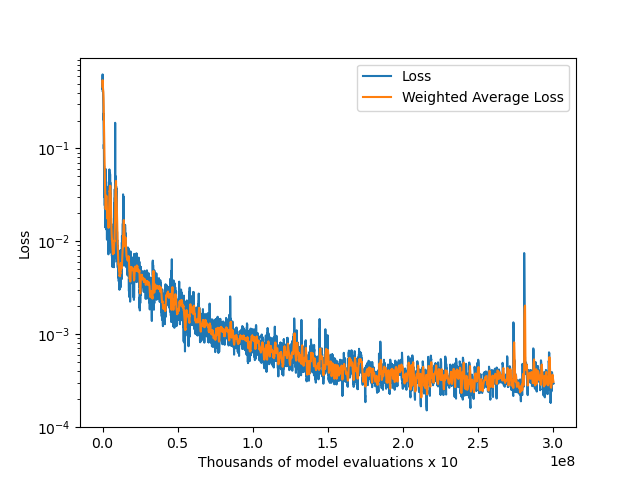

In [26]:
# First lets have a look at the training loss history
plt.figure()
abscissa = np.cumsum(n_inferences)
plt.semilogy(abscissa,  loss_log)
plt.semilogy(abscissa,  weighted_average_log)
plt.xlabel("Thousands of model evaluations x 10")
plt.ylabel("Loss")
plt.legend(["Loss","Weighted Average Loss"])

Sampling points...: 1587it [00:03, 493.01it/s]                                                                         


<IPython.core.display.Javascript object>


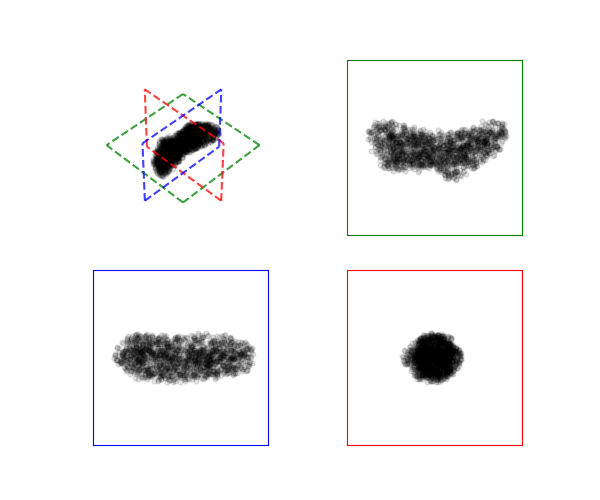

<IPython.core.display.Javascript object>


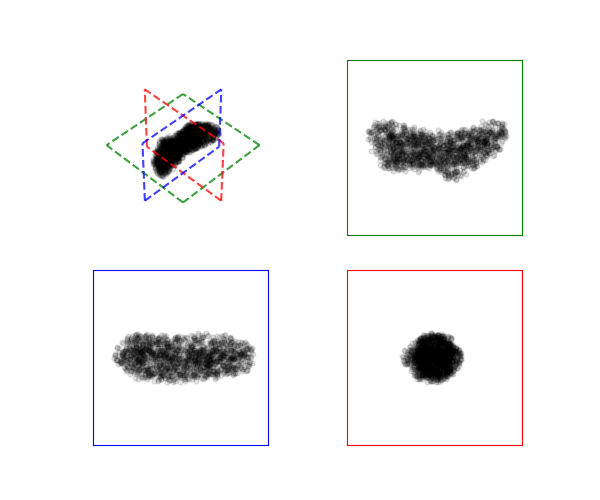

In [27]:
# Lets have a look at the neural density field.
# First with a rejection plot
gravann.plot_model_rejection(model, encoding, views_2d=True, bw=True, N=1500, alpha=0.1, s=50, c=c, crop_p=0.1, progressbar=True)

Sampling points...: 5041it [00:09, 523.54it/s]                                                                         


<IPython.core.display.Javascript object>


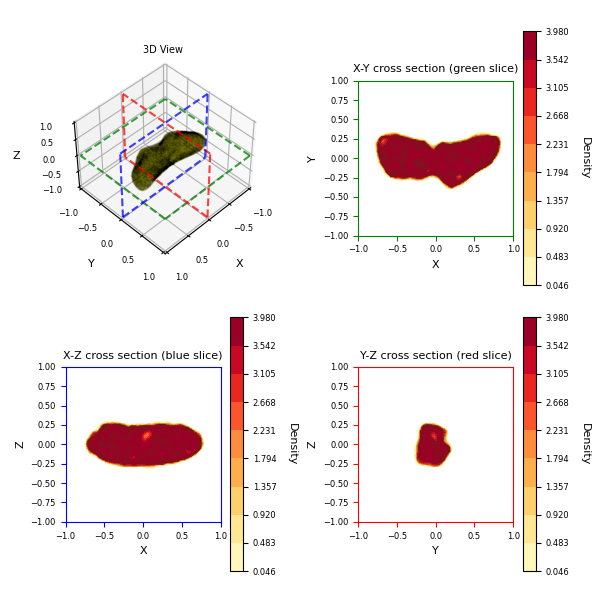

<Axes3DSubplot:title={'center':'3D View'}, xlabel='X', ylabel='Y'>

In [6]:
# Then overlaying a heatmap to the mascons 
gravann.plot_model_vs_mascon_contours(model, encoding, mascon_points, mascon_masses,c=c, progressbar = True, N=5000, heatmap=True)

In [29]:
# Computes the Validation table with rel and abs errors on the predicted acceleration (w.r.t. ground truth) 
# at low, med, high altitudes (see paper). is requires sampling quite a lot, so it takes time 
gravann.validation(model, encoding, mascon_points, mascon_masses, use_acc=True, asteroid_pk_path="3dmeshes/Eros.pk", N=10000, N_integration=300000, batch_size=32, progressbar=True)

Computing validation...:  60%|█████████████████████████████▊                    | 44288/74244 [01:37<01:03, 469.22it/s]

Discarding 4193 of 14744 points in altitude sampler which did not meet requested altitude.


Computing validation...:  73%|████████████████████████████████████▌             | 54272/74244 [02:40<01:46, 187.98it/s]

Discarding 7421 of 14744 points in altitude sampler which did not meet requested altitude.


Computing validation...:  87%|███████████████████████████████████████████▎      | 64256/74244 [03:40<00:54, 183.85it/s]

Discarding 11243 of 14744 points in altitude sampler which did not meet requested altitude.


Computing validation...: 100%|█████████████████████████████████████████████████▉| 74240/74244 [04:40<00:00, 265.14it/s]


,Altitude,Normalized L1 Loss,Normalized Relative Component Loss,RMSE,relRMSE
0,Low Altitude,0.028225,0.018187,0.244254,0.051606
1,High Altitude,0.001959,0.001436,0.010753,0.002525
2,Altitude_0,0.001793,0.001368,0.007143,0.001798
3,Altitude_1,0.000296,0.000271,0.001171,0.000348
4,Altitude_2,0.000042,0.000066,0.000374,0.000170


In [7]:
# Computes the Validation table with rel and abs errors on the predicted acceleration (w.r.t. ground truth) 
# at low, med, high altitudes (see paper). is requires sampling quite a lot, so it takes time 
gravann.validation(model, encoding, mascon_points, mascon_masses, use_acc=True, asteroid_pk_path="3dmeshes/Eros.pk", N=10000, N_integration=300000, batch_size=32, progressbar=True)

Computing validation...:  60%|█████████████████████████████▊                    | 44288/74244 [01:38<01:07, 442.85it/s]

Discarding 4193 of 14744 points in altitude sampler which did not meet requested altitude.


Computing validation...:  73%|████████████████████████████████████▌             | 54272/74244 [02:42<01:45, 189.98it/s]

Discarding 7421 of 14744 points in altitude sampler which did not meet requested altitude.


Computing validation...:  87%|███████████████████████████████████████████▎      | 64256/74244 [03:44<00:53, 186.44it/s]

Discarding 11243 of 14744 points in altitude sampler which did not meet requested altitude.


Computing validation...: 100%|█████████████████████████████████████████████████▉| 74240/74244 [04:43<00:00, 261.71it/s]


,Altitude,Normalized L1 Loss,Normalized Relative Component Loss,RMSE,relRMSE
0,Low Altitude,0.028174,0.018238,0.272122,0.055747
1,High Altitude,0.002311,0.001711,0.012548,0.002981
2,Altitude_0,0.002090,0.001599,0.007827,0.001992
3,Altitude_1,0.000416,0.000386,0.001434,0.000446
4,Altitude_2,0.000052,0.000081,0.000192,0.000100


In [19]:
# Shows how the relative error is distribued along the asteroid surface (at some altitude) 
gravann.plot_model_mascon_acceleration("3dmeshes/Eros.pk", model, encoding, mascon_points, mascon_masses, plane="XY", c=c, N=5000, logscale=False, altitude=0.1)

Sampling points at altitude
Discarding 7421 of 14744 points in altitude sampler which did not meet requested altitude.
Got  5000  points.
Splitting in left / right hemisphere
Left:  2413  points.
Right:  2587  points.


NameError: name 'sobol_points' is not defined

<IPython.core.display.Javascript object>


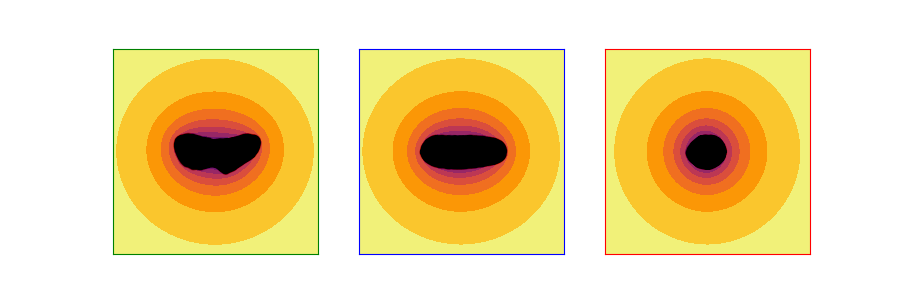

<AxesSubplot:>

In [15]:
# Shows the Contour plot of the gravity potential generated by the neural density field.
gravann.plot_potential_contours(model, encoding, mascon_points)

#### Saving the model

In [30]:
# Uncomment to save the model
#torch.save(model.state_dict(), "models/eros_1.5e-4.mdl")

In [10]:
y = torch.ones(1000,1)*0.1
z = torch.ones(1000,1)*0.1
x = torch.linspace(-1,1,1000).view(-1,1)
points = torch.concat((x,y,z), dim=1)

<IPython.core.display.Javascript object>


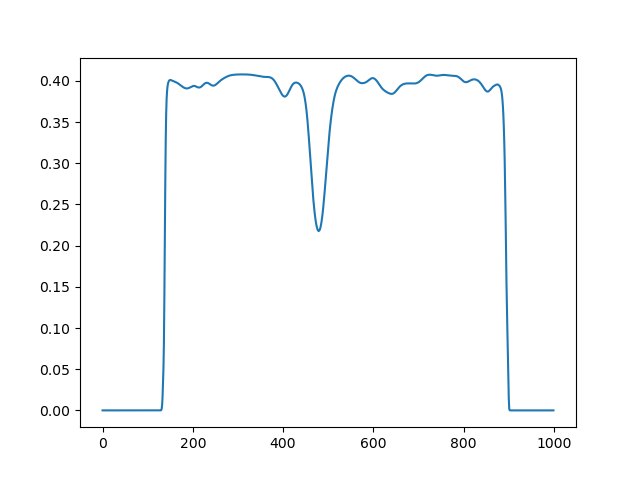

In [11]:
plt.figure()
plt.plot(model(points).detach().cpu().numpy())

In [35]:
model(points)

tensor([[9.6485e-07],
        [1.1288e-06],
        [1.3076e-06],
        [1.5125e-06],
        [1.7323e-06],
        [1.9744e-06],
        [2.2277e-06],
        [2.4922e-06],
        [2.7567e-06],
        [3.0249e-06],
        [3.2932e-06],
        [3.5465e-06],
        [3.7812e-06],
        [3.9898e-06],
        [4.1761e-06],
        [4.3362e-06],
        [4.4592e-06],
        [4.5523e-06],
        [4.6119e-06],
        [4.6454e-06],
        [4.6305e-06],
        [4.5933e-06],
        [4.5300e-06],
        [4.4443e-06],
        [4.3288e-06],
        [4.2021e-06],
        [4.0419e-06],
        [3.8780e-06],
        [3.6769e-06],
        [3.4645e-06],
        [3.2261e-06],
        [2.9542e-06],
        [2.6487e-06],
        [2.2985e-06],
        [1.9036e-06],
        [1.4491e-06],
        [9.2015e-07],
        [3.2410e-07],
        [3.6880e-07],
        [1.1511e-06],
        [2.0415e-06],
        [3.0436e-06],
        [4.1611e-06],
        [5.3793e-06],
        [6.7167e-06],
        [8